# CPE

**Common Platform Enumeration (CPE)** is a structured naming scheme for information technology systems, software, and packages. Based upon the generic syntax for Uniform Resource Identifiers (URI), CPE includes a formal name format, a method for checking names against a system, and a description format for binding text and tests to a name. This method of naming is known as a well-formed CPE name (WFN)

> source: [cpe.mitre.org/specification](https://cpe.mitre.org/specification/)



You can see this notebook directly via:
- [GitHub](https://github.com/LimberDuck/limberduck.org/blob/master/docs/notebooks/cpe/cpe.ipynb)
- [Jupter nbviewer](https://nbviewer.org/github/LimberDuck/limberduck.org/blob/master/docs/notebooks/cpe/cpe.ipynb)

## Generation time

In [1]:
from datetime import datetime, timezone, timedelta

timezone_offset = 0.0
tzinfo = timezone(timedelta(hours=timezone_offset))
generation_time = datetime.now(tzinfo).strftime('%Y-%m-%d %H:%M:%S %z')
print(generation_time)

2022-03-20 21:48:07 +0000


## Creative Commons

This notebook and generated diagrams are released with [Creative Commons liecense (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/deed.en).

<a href="https://creativecommons.org/licenses/by/4.0/deed.en"><img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by.png" alt="CC BY 4.0" width="100px"/></a>

In [2]:
import requests
import urllib3

urllib3.disable_warnings()

urls = ['https://mirrors.creativecommons.org/presskit/icons/cc.xlarge.png',
       'https://mirrors.creativecommons.org/presskit/icons/by.xlarge.png']
for url in urls:
    file_name = url.split("/")[-1:][0]
    print(file_name)

    file = requests.get(url, verify=False)
    open(file_name, 'wb').write(file.content)

cc.xlarge.png
by.xlarge.png


## CPE data downloading

All CPE stats are taken from [nvd.nist.gov/products/cpe/statistics](https://nvd.nist.gov/products/cpe/statistics)

In [3]:
from urllib.request import urlopen
import ssl
from bs4 import BeautifulSoup, SoupStrainer

def get_data(url):

    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE

    page = urlopen(url, context=ctx)
    html = page.read().decode("utf-8")
    
    product = SoupStrainer('table')
    soup = BeautifulSoup(html, "html.parser", parse_only=product)
    
    return soup

url = "https://nvd.nist.gov/products/cpe/statistics"
data = get_data(url)

print(len(data))

14


## New CPE entries

### CPE data parsing

In [4]:
import pandas as pd

def pars(data):
    data_table = []
    
    for table in data:
        table_id = table['id']
        table_year = table_id[-4:]
        table_rows = table.find_all("tr")
        number_of_new_cpe_entries_yearly = 0
        number_of_new_cpe_entries_list = []
        data_row = []
        for table_row in table_rows:
            data = table_row.find_all("td")
            
            if data:
                number_of_new_cpe_entries = int(data[1].string.replace(",",""))
                
                number_of_new_cpe_entries_list.append(number_of_new_cpe_entries)
                
                number_of_new_cpe_entries_yearly += number_of_new_cpe_entries
        
        while len(number_of_new_cpe_entries_list) < 12:
            number_of_new_cpe_entries_list.append(0)

        data_row.append(table_year)
        data_row.append(number_of_new_cpe_entries_yearly)
        data_row = data_row + number_of_new_cpe_entries_list

        data_table.append(data_row)
    
    data_columns = ['Year', 'Summary', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    df = pd.DataFrame (data_table, columns = data_columns)
    df.sort_values(by=['Year'], inplace=True)    
    df.reset_index(drop=True, inplace=True)
    df.index += 1
    return df
    
parsed_data = pars(data)

parsed_data.style.bar(subset=['Summary'], color='#FF6200')

,Year,Summary,January,February,March,April,May,June,July,August,September,October,November,December
1,2009,5786,181,422,830,639,612,209,241,110,330,102,1960,150
2,2010,11094,990,234,509,1106,803,886,426,1252,707,1336,1026,1819
3,2011,9263,702,925,583,2252,818,682,430,390,423,470,737,851
4,2012,23235,1148,1003,1622,2501,3228,2259,3124,2887,1583,1830,1110,940
5,2013,15671,1460,1105,1138,1271,932,989,1623,1359,1140,1941,1327,1386
6,2014,16714,1552,1151,1644,2103,2175,1447,1606,886,885,260,1380,1625
7,2015,6503,758,654,849,838,429,736,446,564,81,216,144,788
8,2016,11081,2450,535,871,699,733,1474,321,762,979,455,696,1106
9,2017,18668,746,888,1072,1936,1498,1216,1366,1890,1516,1596,2587,2357
10,2018,56530,2276,2405,1578,2525,10491,5163,3707,3896,3723,10862,6567,3337


### CPE data saving

CSV file is available in GitHub repository, see:

- [file via GitHub](https://github.com/LimberDuck/limberduck.org/blob/master/docs/notebooks/cpe/cpe-number-of-new-entries.csv)
- [file directly](https://raw.githubusercontent.com/LimberDuck/limberduck.org/master/docs/notebooks/cpe/cpe-number-of-new-entries.csv)

In [5]:
csv_filename = 'cpe-number-of-new-entries.csv'

parsed_data.to_csv(csv_filename, index=False)

### CPE data ploting

PNG files are available in GitHub repository with two background versions, see: 

- [file via GitHub (white background)](https://github.com/LimberDuck/limberduck.org/blob/master/docs/notebooks/cpe/cpe-number-of-new-entries-bg-white.png)
- [file via GitHub (transparent background)](https://github.com/LimberDuck/limberduck.org/blob/master/docs/notebooks/cpe/cpe-number-of-new-entries-bg-transparent.png)
- [file directly (white background)](https://raw.githubusercontent.com/LimberDuck/limberduck.org/master/docs/notebooks/cpe/cpe-number-of-new-entries-bg-white.png)
- [file directly (transparent background)](https://raw.githubusercontent.com/LimberDuck/limberduck.org/master/docs/notebooks/cpe/cpe-number-of-new-entries-bg-transparent.png)

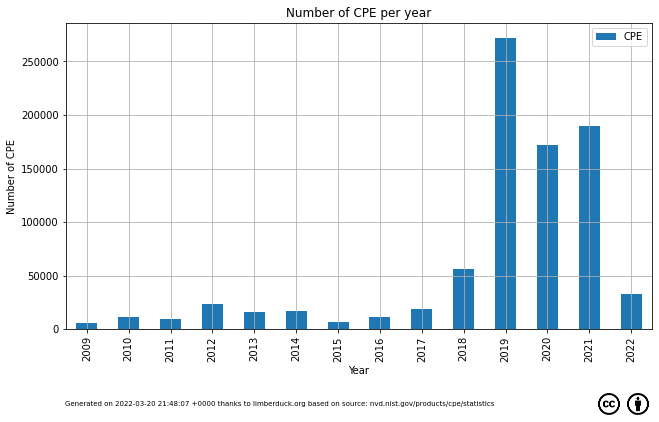

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import urllib

df = pd.read_csv(csv_filename)

df.plot(x='Year', 
        xlabel='Year',
        y='Summary', 
        ylabel='Number of CPE',
        kind='bar', 
        title='Number of CPE per year')
plt.tight_layout()
plt.legend(['CPE'])
plt.figtext(0.16, 0.02, f"Generated on {generation_time} thanks to limberduck.org based on source: nvd.nist.gov/products/cpe/statistics", ha="left", fontsize=7)
fig = plt.gcf()
fig.set_size_inches(10,6)
fig.patch.set_facecolor('white')
plt.grid(True)

img_cc = plt.imread('cc.xlarge.png')
newax_cc = fig.add_axes([0.88, 0.0, 0.05, 0.05], anchor='NE', zorder=-1)
newax_cc.imshow(img_cc)
newax_cc.axis('off')
img_by = plt.imread('by.xlarge.png')
newax_by = fig.add_axes([0.92, 0.0, 0.05, 0.05], anchor='NE', zorder=-1)
newax_by.imshow(img_by)
newax_by.axis('off')

plt.savefig('cpe-number-of-new-entries-bg-white.png', dpi = 300, facecolor = 'white')
plt.savefig('cpe-number-of-new-entries-bg-transparent.png', dpi = 300, transparent = True)